# Banking customer churn prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 2. Data Collection and exploration

In [2]:
#load data
df = pd.read_csv(r"D:\AI\data\datasets-1\Bank_churn_modelling.csv")
df.shape

(10000, 14)

In [3]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
df.describe()

RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9985.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     5.013721   
std     2886.89568  7.193619e+04     96.653299     10.487806     2.892213   
min        1.00000  1.556570e+07    350.000000     18.000000     0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000     3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000     5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000     7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000    10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count      9990.000000  10000.000000  
mean     100127.441333      0.203700  
std       57497.228065      0.402769  
min          11.580000      0.000000  
25%       51112.885000      0.000000  
50%      100238.110000      0.000000  
75%      149400.922500      0.000000  
max      199992.480000      1.000000


Analyze:
    
        - unwanted columns: RowNumber, CustomerId, Surname
        - Demographic info: Age, Gender, geo
        - financial info: Balance, Salary, creditscore
        - relation with bank: Tenure, numofproducts, isactivemember
        - target: Exited
        - atleast 25% of customers have 0 balance in their account

## 3. Data cleaning

### Handling missing data
    - data is missing because it does not exist
        - Numeric: convert the column into binary or categorical, add one category as "unavailable"/"others"
        - Categoric: replace all missing values by an additional/existing category "others"/"not known"
        
        
    - data exists, but it is missing because of some human or system error
        - if any row has more than 60% of values missing - drop the row
        - if any column has more than 70%-80% values missing - drop the column
        - for rows having upto 5%-10% (depending on size of data) missing data - statistical imputation
            - Categoric: Nominal: Mode
            - Categoric: Ordinal: Median
            - Numeric: skewness > 0.1 or skewness < -0.1 => median
            - Numeric: skewness is b/w -0.1 to +0.1 => Mean
          - for rows having more than 10% of data missing: ML based imputation

In [5]:
# check for duplicates
df.duplicated().sum()

0

In [6]:
# check for missing values
df.isnull().sum()

RowNumber           0
CustomerId          0
Surname             0
CreditScore         0
Geography           0
Gender              0
Age                 0
Tenure             15
Balance             0
NumOfProducts       0
HasCrCard           0
IsActiveMember      0
EstimatedSalary    10
Exited              0
dtype: int64

In [7]:
df[['Tenure','EstimatedSalary']].skew()

Tenure             0.010333
EstimatedSalary    0.001322
dtype: float64

In [8]:
# as skewness is almost 0, the variables are normally distributed, we will impute the missing values by mean
df.Tenure.fillna(df.Tenure.mean(),inplace=True)
df.EstimatedSalary.fillna(df.EstimatedSalary.mean(),inplace=True)

In [9]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
## drop the unwanted columns
print(df.shape)
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)
print(df.shape)

(10000, 14)
(10000, 11)


In [11]:
# check for outliers
df.skew()

C:\Users\admin\AppData\Local\Temp/ipykernel_18488/3256115495.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


CreditScore       -0.071607
Age                1.011320
Tenure             0.010341
Balance           -0.141109
NumOfProducts      0.745568
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.001323
Exited             1.471611
dtype: float64

## 4. Feature Selection
### Data visualization
#### Univariate Analysis

In [12]:
import plotly.express as px

In [13]:
for col in df.columns:
    fig = px.histogram(df,x=col,width=850,height=400)
    fig.show()

#### Bivariate Analysis

In [14]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [15]:
sns.set_theme()

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



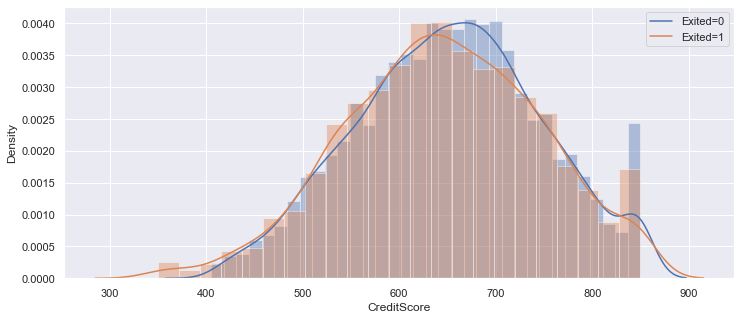

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



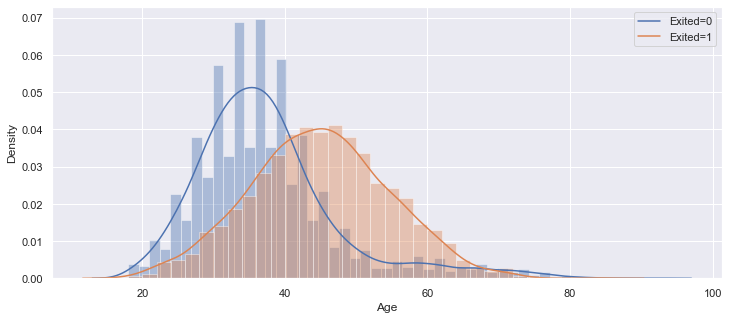

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



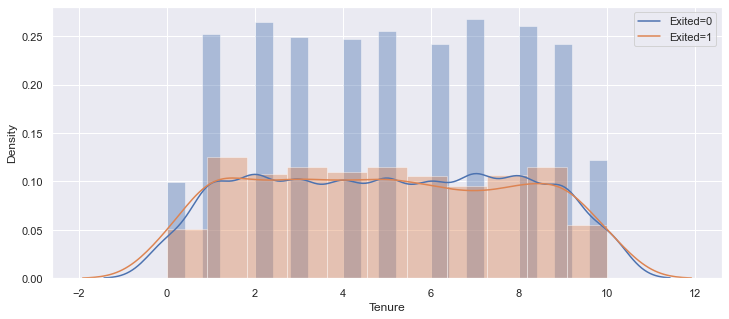

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



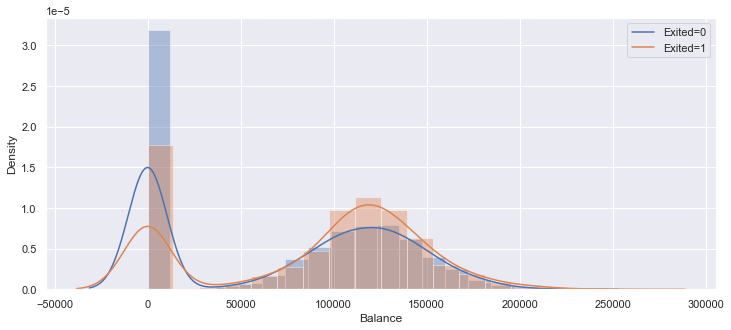

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



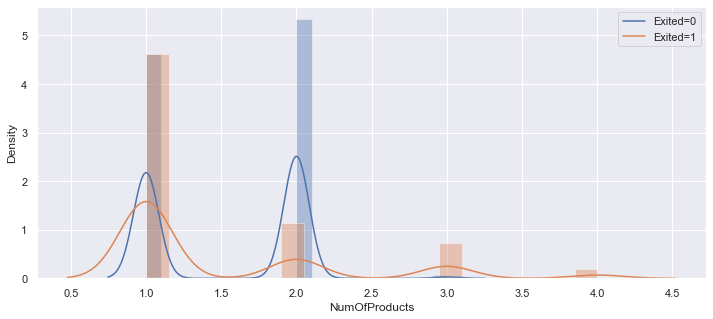

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



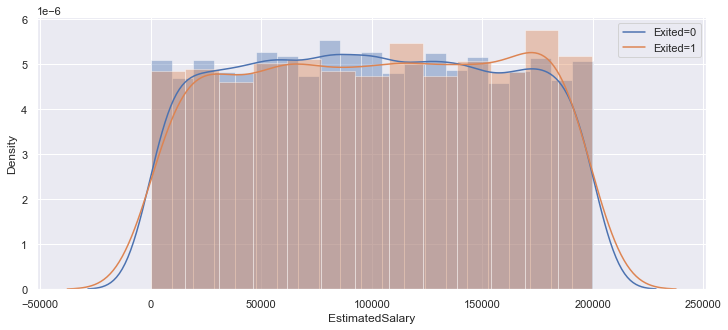

In [16]:
# numeric v/s categoric
nums = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts',  'EstimatedSalary']

for col in nums:
    plt.figure(figsize=(12,5))
    sns.distplot(df[col][df.Exited==0])
    sns.distplot(df[col][df.Exited==1])
    plt.legend(['Exited=0','Exited=1'])
    plt.show()


In [17]:
# Categoric v/s categoric
# geography v/s exited

pivot = pd.crosstab(df.Geography,df.Exited,margins=True)
pivot

Exited        0     1    All
Geography                   
France     4204   810   5014
Germany    1695   814   2509
Spain      2064   413   2477
All        7963  2037  10000

In [18]:
pivot[1]/pivot['All']

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
All        0.203700
dtype: float64

In [19]:
# Gender v/s Exited
pivot = pd.crosstab(df.Gender,df.Exited,margins=True)
pivot[1] / pivot['All']

Gender
Female    0.250715
Male      0.164559
All       0.203700
dtype: float64

In [20]:
# HasCrCard v/s Exited
pivot = pd.crosstab(df.HasCrCard,df.Exited,margins=True)
pivot[1] / pivot['All']

HasCrCard
0      0.208149
1      0.201843
All    0.203700
dtype: float64

In [21]:
# IsActiveMember v/s Exited
pivot = pd.crosstab(df.IsActiveMember,df.Exited,margins=True)
pivot[1] / pivot['All']

IsActiveMember
0      0.268509
1      0.142691
All    0.203700
dtype: float64

#### Multivariate Analysis

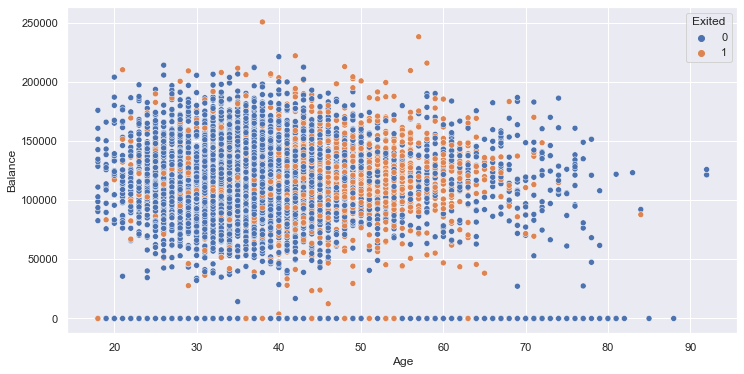

In [22]:
# age v/s Balance v/s Exited
plt.figure(figsize=(12,6))
sns.scatterplot(x='Age',y='Balance',hue='Exited',data=df)
plt.show()

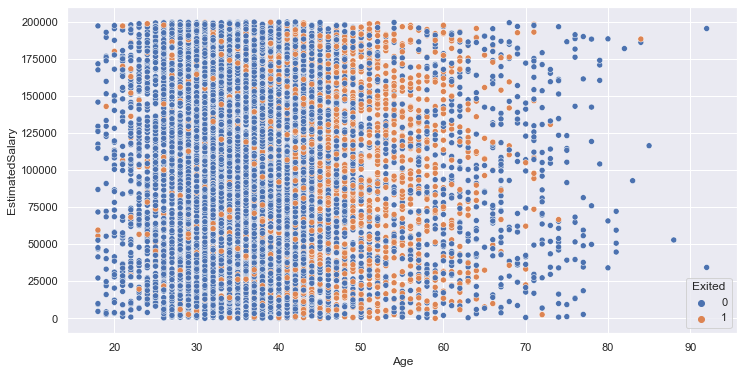

In [23]:
# age v/s EstimatedSalary v/s Exited
plt.figure(figsize=(12,6))
sns.scatterplot(x='Age',y='EstimatedSalary',hue='Exited',data=df)
plt.show()

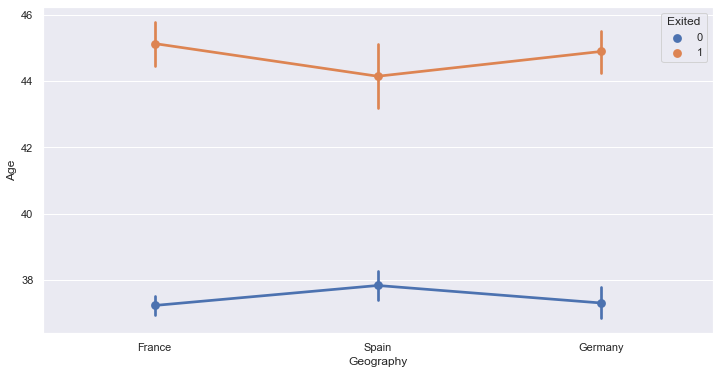

In [24]:
# age v/s Geography v/s Exited
plt.figure(figsize=(12,6))
sns.pointplot(x='Geography',y='Age',hue='Exited',data=df)
plt.show()

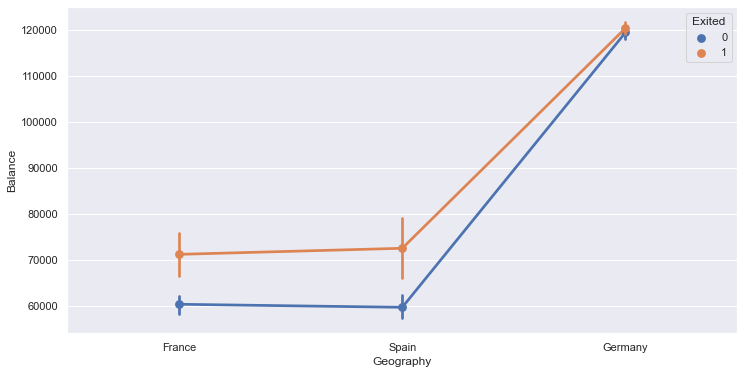

In [25]:
# age v/s Geography v/s Exited
plt.figure(figsize=(12,6))
sns.pointplot(x='Geography',y='Balance',hue='Exited',data=df)
plt.show()

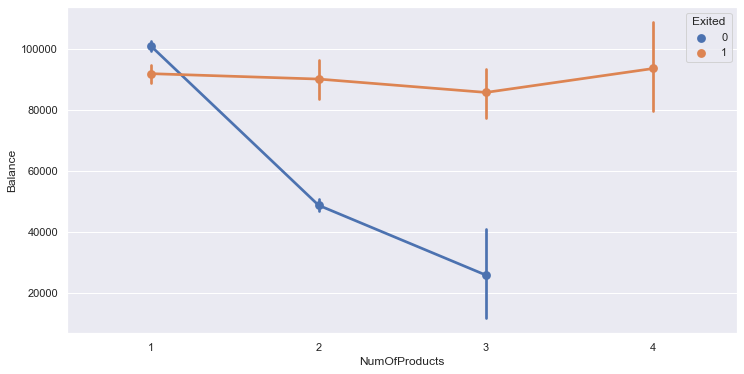

In [26]:
# age v/s Geography v/s Exited
plt.figure(figsize=(12,6))
sns.pointplot(x='NumOfProducts',y='Balance',hue='Exited',data=df)
plt.show()

### statistical research
#### Correlation Analysis

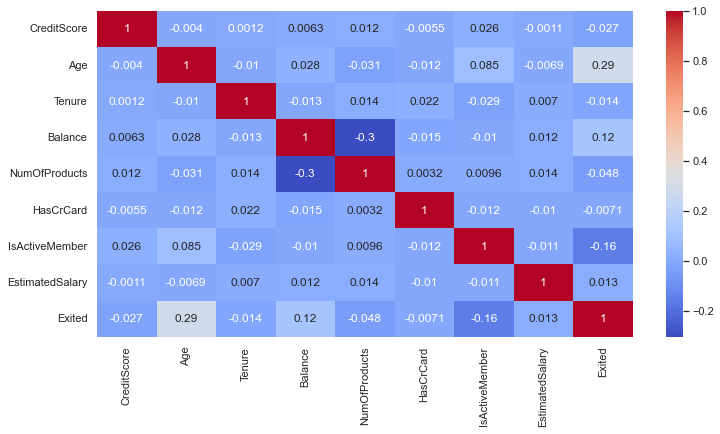

In [27]:
cor = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,annot=True,cmap='coolwarm')
plt.show()

Correlation helps in following way - 

    - it helps in identifying features which are having linear relation with the target attribute
    - In machine learning, supervised ML, there are two types of algorithms
    
        - linear models
            - these are the techniques which primarily learn linear relationship between features and target
            - these mostly lightweight, faster, can give good results with less data
            - can be used if correlation analysis says, most features have good correlation with target attribute
            - linear regression, logistic regression, linear SVM, naive bayes
            
            
        - non linear models
            - these can additionally learn non linear complex relationship between features and target
            - these are heavy, slow, computaionally expensive, need more data to train
            - can be used if features do not have much stronger correlation with target, that means they have mostly some non linear relation with target
            - decision tree, ensemble techniques (random forest, xboost etc.), neural networks


In [28]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [29]:
x = df[['CreditScore', 'Geography', 'Gender', 'Age',  'Balance','NumOfProducts', 'IsActiveMember']]

y = df.Exited

## 5. Preprocessing of features

In [30]:
x.head(8)

CreditScore Geography  Gender  Age    Balance  NumOfProducts  \
0          619    France  Female   42       0.00              1   
1          608     Spain  Female   41   83807.86              1   
2          502    France  Female   42  159660.80              3   
3          699    France  Female   39       0.00              2   
4          850     Spain  Female   43  125510.82              1   
5          645     Spain    Male   44  113755.78              2   
6          822    France    Male   50       0.00              2   
7          376   Germany  Female   29  115046.74              4   

   IsActiveMember  
0               1  
1               1  
2               0  
3               0  
4               1  
5               0  
6               1  
7               0

In [31]:
pd.get_dummies(df.Gender)

Female  Male
0          1     0
1          1     0
2          1     0
3          1     0
4          1     0
...      ...   ...
9995       0     1
9996       0     1
9997       1     0
9998       0     1
9999       1     0

[10000 rows x 2 columns]

In [32]:
# encoding categoric attributes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

prep = ColumnTransformer([('ohe',OneHotEncoder(drop='first'),[1,2]),],remainder='passthrough')
prep.fit(x)

x2 = pd.DataFrame(prep.transform(x))
x2.head(8)

0    1    2      3     4          5    6    7
0  0.0  0.0  0.0  619.0  42.0       0.00  1.0  1.0
1  0.0  1.0  0.0  608.0  41.0   83807.86  1.0  1.0
2  0.0  0.0  0.0  502.0  42.0  159660.80  3.0  0.0
3  0.0  0.0  0.0  699.0  39.0       0.00  2.0  0.0
4  0.0  1.0  0.0  850.0  43.0  125510.82  1.0  1.0
5  0.0  1.0  1.0  645.0  44.0  113755.78  2.0  0.0
6  0.0  0.0  1.0  822.0  50.0       0.00  2.0  1.0
7  1.0  0.0  0.0  376.0  29.0  115046.74  4.0  0.0

In [33]:
# train test split
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x2,y,test_size=0.2,random_state=3,stratify=y)
print(x.shape,xtrain.shape,xtest.shape)
print(y.shape,ytrain.shape,ytest.shape)

(10000, 7) (8000, 8) (2000, 8)
(10000,) (8000,) (2000,)


## 6. Apply Machine Learning algorithm

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [35]:
# trianing the model using trrian data
model.fit(xtrain,ytrain)

LogisticRegression()

## 7. Performance Analysis

In [36]:
# age = 25, balance = 120000, nop = 2, gender = male, geo = france, iam = 1, cs=650
newcust =[[650,'France','Male',25,120000,2,1]]
newcust = prep.transform(newcust)
model.predict(newcust)

array([0], dtype=int64)

In [37]:
# we will feed the test data to model to get predictions
ypred = model.predict(xtest)

# accuracy of model on test data
from sklearn import metrics

metrics.accuracy_score(ytest,ypred)

0.7865

In [38]:
# calculating recall
metrics.recall_score(ytest,ypred)

0.044226044226044224

In [39]:
# calculating precision
metrics.precision_score(ytest,ypred)

0.32142857142857145

In [40]:
metrics.f1_score(ytest,ypred)

0.07775377969762419

In [41]:
metrics.confusion_matrix(ytest,ypred)

array([[1555,   38],
       [ 389,   18]], dtype=int64)

In [42]:
pd.DataFrame(metrics.confusion_matrix(ytest,ypred))

0   1
0  1555  38
1   389  18

In [43]:
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1593
           1       0.32      0.04      0.08       407

    accuracy                           0.79      2000
   macro avg       0.56      0.51      0.48      2000
weighted avg       0.70      0.79      0.72      2000



## 5. Preprocessing of features

In [44]:
x.head()

CreditScore Geography  Gender  Age    Balance  NumOfProducts  \
0          619    France  Female   42       0.00              1   
1          608     Spain  Female   41   83807.86              1   
2          502    France  Female   42  159660.80              3   
3          699    France  Female   39       0.00              2   
4          850     Spain  Female   43  125510.82              1   

   IsActiveMember  
0               1  
1               1  
2               0  
3               0  
4               1

In [45]:
# encoding categoric attributes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

prep = ColumnTransformer([('ohe',OneHotEncoder(drop='first'),[1,2]),('sc',StandardScaler(),[0,3,4,5])],remainder='passthrough')
prep.fit(x)

x2 = pd.DataFrame(prep.transform(x))
x2.head(8)

0    1    2         3         4         5         6    7
0  0.0  0.0  0.0 -0.326221  0.293517 -1.225848 -0.911583  1.0
1  0.0  1.0  0.0 -0.440036  0.198164  0.117350 -0.911583  1.0
2  0.0  0.0  0.0 -1.536794  0.293517  1.333053  2.527057  0.0
3  0.0  0.0  0.0  0.501521  0.007457 -1.225848  0.807737  0.0
4  0.0  1.0  0.0  2.063884  0.388871  0.785728 -0.911583  1.0
5  0.0  1.0  1.0 -0.057205  0.484225  0.597329  0.807737  0.0
6  0.0  0.0  1.0  1.774174  1.056346 -1.225848  0.807737  1.0
7  1.0  0.0  0.0 -2.840488 -0.946079  0.618019  4.246377  0.0

In [46]:
# train test split
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x2,y,test_size=0.2,random_state=3,stratify=y)
print(x.shape,xtrain.shape,xtest.shape)
print(y.shape,ytrain.shape,ytest.shape)

(10000, 7) (8000, 8) (2000, 8)
(10000,) (8000,) (2000,)


## 6. Apply Machine Learning algorithm

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [48]:
# trianing the model using trrian data
model.fit(xtrain,ytrain)

LogisticRegression()

## 7. Performance Analysis

In [49]:
# age = 25, balance = 120000, nop = 2, gender = male, geo = france, iam = 1, cs=650
newcust =[[650,'France','Male',25,120000,2,1]]
newcust = prep.transform(newcust)
model.predict(newcust)

array([0], dtype=int64)

In [50]:
# we will feed the test data to model to get predictions
ypred = model.predict(xtest)

# accuracy of model on test data
from sklearn import metrics

metrics.accuracy_score(ytest,ypred)

0.8115

In [51]:
# calculating recall
metrics.recall_score(ytest,ypred)

0.21375921375921375

In [52]:
# calculating precision
metrics.precision_score(ytest,ypred)

0.6041666666666666

In [53]:
metrics.f1_score(ytest,ypred)

0.31578947368421045

In [54]:
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.60      0.21      0.32       407

    accuracy                           0.81      2000
   macro avg       0.72      0.59      0.60      2000
weighted avg       0.78      0.81      0.77      2000



## KNN Implementation

In [55]:
from sklearn.neighbors import KNeighborsClassifier

model2 = KNeighborsClassifier(n_neighbors=3)
# train the model
model2.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=3)

In [56]:
# assess the performance of model
ypred2 = model2.predict(xtest)

print(metrics.classification_report(ytest,ypred2))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.65      0.53      0.58       407

    accuracy                           0.85      2000
   macro avg       0.77      0.73      0.74      2000
weighted avg       0.84      0.85      0.84      2000



## Decision Tree Implementation

In [57]:
from sklearn import tree

In [58]:
model3 = tree.DecisionTreeClassifier(criterion='gini',random_state=3)
model3.fit(xtrain,ytrain)

DecisionTreeClassifier(random_state=3)

In [59]:
# performance analysis using test data
ypred = model3.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1593
           1       0.49      0.55      0.52       407

    accuracy                           0.79      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.80      0.79      0.80      2000



In [60]:
# performance analysis using train data
ypred = model3.predict(xtrain)
print(metrics.classification_report(ytrain,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6370
           1       1.00      1.00      1.00      1630

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



## Controlling Overfitting

In [61]:
model4 = tree.DecisionTreeClassifier(criterion='gini',random_state=3,max_depth=8,min_samples_leaf=12,
                                    min_samples_split=30)
model4.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=12, min_samples_split=30,
                       random_state=3)

In [62]:
# performance analysis using test data
ypred = model4.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1593
           1       0.70      0.57      0.63       407

    accuracy                           0.86      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.86      0.86      0.86      2000



In [63]:
# performance analysis using train data
ypred = model4.predict(xtrain)
print(metrics.classification_report(ytrain,ypred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6370
           1       0.73      0.58      0.64      1630

    accuracy                           0.87      8000
   macro avg       0.81      0.76      0.78      8000
weighted avg       0.86      0.87      0.86      8000



### Overfitting

    - performance on test data = low
    - performance on train data = high
    
#### Why overfitting happens?
    - presence of noisty observations, noisy features
    - small data - lack of data
    - Learning algorithm used is more complex
    
#### How to handle overfitting?
    - drop some unwanted columns, less important columns
    - collect more data- collect more rows, no need to collect more columns
    - try a slightly simpler algorithm
    - for decision tree - decrease max params (max_depth, max_leaf_nodes), increase value for min params (min_samples_leaf, min_samples_split).
    
    
### Underfitting

    - performance of model on test data = low
    - performance of model on train data = low
    
#### Why underfitting happens?
    - presence of noisy observations
    - lack for informative features
    - learning algorithm used is less efficient
    
#### How to handle underfitting?
    - drop some noisy rows, outliers
    - collect more columns, no need collect rows
    - create/derive new columns
    - try more complex learning algorithm
    - for decision tree - increase max params (max_depth, max_leaf_nodes), decrease value for min params (min_samples_leaf, min_samples_split).

### Hyperparameter tuning using gridsearch

In [64]:
params = {"max_depth":np.arange(5,12,1),
         'min_samples_leaf':np.arange(5,40,5),
         'min_samples_split':np.arange(5,60,10),
         'max_leaf_nodes':np.arange(30,100,10)}
params

{'max_depth': array([ 5,  6,  7,  8,  9, 10, 11]),
 'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35]),
 'min_samples_split': array([ 5, 15, 25, 35, 45, 55]),
 'max_leaf_nodes': array([30, 40, 50, 60, 70, 80, 90])}

In [65]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(tree.DecisionTreeClassifier(random_state=3),param_grid=params,
                     scoring='f1',cv=5,n_jobs=-1,verbose=True)

In [66]:
search.fit(x2,y)

Fitting 5 folds for each of 2058 candidates, totalling 10290 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=3), n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11]),
                         'max_leaf_nodes': array([30, 40, 50, 60, 70, 80, 90]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35]),
                         'min_samples_split': array([ 5, 15, 25, 35, 45, 55])},
             scoring='f1', verbose=True)

In [67]:
search.best_score_

0.5846928858767954

In [68]:
search.best_params_

{'max_depth': 8,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 55}

### Visualize the tree

In [69]:
# encoding categoric attributes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

prep = ColumnTransformer([('ohe',OneHotEncoder(drop='first'),[1,2]),],remainder='passthrough')
prep.fit(x)

x2 = pd.DataFrame(prep.transform(x))
# train test split
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x2,y,test_size=0.2,random_state=3,stratify=y)

In [70]:
prep.get_feature_names()

['ohe__x0_Germany',
 'ohe__x0_Spain',
 'ohe__x1_Male',
 'CreditScore',
 'Age',
 'Balance',
 'NumOfProducts',
 'IsActiveMember']

In [71]:
model4 = tree.DecisionTreeClassifier(criterion='gini',random_state=3,max_depth=7,min_samples_leaf=12,
                                    min_samples_split=30,max_leaf_nodes=40)
model4.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=40, min_samples_leaf=12,
                       min_samples_split=30, random_state=3)

In [72]:
# pip install graphviz
import graphviz

In [73]:
0.3204*8000

2563.2000000000003

In [74]:
0.206*5694 + 0.487*2306

2295.986

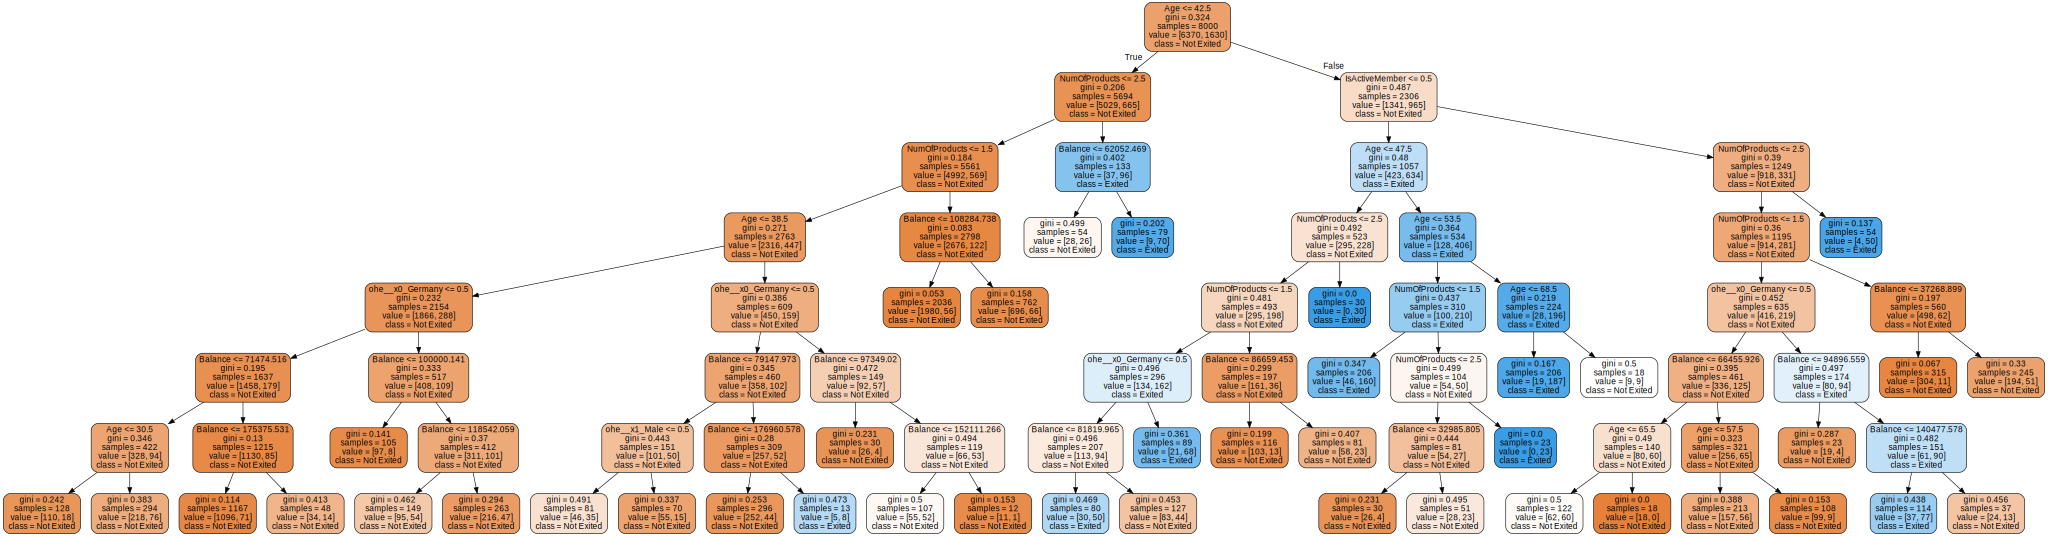

In [75]:
graphdata = tree.export_graphviz(model4,class_names=['Not Exited','Exited'],
                            feature_names=prep.get_feature_names(),filled=True,rounded=True)
graph = graphviz.Source(graphdata)
graph

In [76]:
graph.format = 'png'
graph.render("mydtree",view=True)

'mydtree.png'

## Random Forest Implementation

In [99]:
from sklearn.ensemble import RandomForestClassifier

model5 = RandomForestClassifier(n_estimators=200,random_state=5,max_depth=9,oob_score=True,min_samples_leaf=5,
                               class_weight='balanced')

# train the model with train data
model5.fit(xtrain,ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=5,
                       n_estimators=200, oob_score=True, random_state=5)

In [100]:
# assess the performance on test data
# performance analysis using test data
ypred = model5.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1593
           1       0.57      0.74      0.64       407

    accuracy                           0.83      2000
   macro avg       0.75      0.80      0.77      2000
weighted avg       0.86      0.83      0.84      2000



## Adaboost implementation

In [103]:
from sklearn.ensemble import AdaBoostClassifier

model6 = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='gini',class_weight='balanced',
                                                                      max_depth=1,),n_estimators=300)
model6.fit(xtrain,ytrain)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1),
                   n_estimators=300)

In [104]:
# performance analysis using test data
ypred = model6.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.75      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.78      0.80      2000



## Gradient boosting

In [105]:
from sklearn.ensemble import GradientBoostingClassifier
model7 = GradientBoostingClassifier(learning_rate=0.02,n_estimators=1000,tol=0.00001,max_depth=2)
model7.fit(xtrain,ytrain)

GradientBoostingClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000,
                           tol=1e-05)

In [106]:
# performance analysis using test data
ypred = model7.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



## XGBoost

In [107]:
# pip install xgboost

In [111]:
from xgboost import XGBClassifier
model9 = XGBClassifier(n_estimators=500,n_jobs=-1)

In [112]:
model9.fit(xtrain,ytrain)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
# performance analysis using test data
ypred = model9.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1593
           1       0.63      0.49      0.55       407

    accuracy                           0.84      2000
   macro avg       0.75      0.71      0.72      2000
weighted avg       0.83      0.84      0.83      2000



## Stacking

In [114]:
# pip install mlxtend

In [119]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier


base1 = KNeighborsClassifier(n_neighbors=3)
base2 = DecisionTreeClassifier(random_state=3,class_weight='balanced',max_depth=8,min_samples_leaf=10)
base3 = AdaBoostClassifier(n_estimators=500,random_state=3)
base4 = RandomForestClassifier(n_estimators=500,random_state=3,class_weight='balanced')


meta = LogisticRegression()

model9 = StackingClassifier(classifiers=[base1,base2,base3,base4],meta_classifier=meta)
model9.fit(xtrain,ytrain)

StackingClassifier(classifiers=[KNeighborsClassifier(n_neighbors=3),
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=8,
                                                       min_samples_leaf=10,
                                                       random_state=3),
                                AdaBoostClassifier(n_estimators=500,
                                                   random_state=3),
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=500,
                                                       random_state=3)],
                   meta_classifier=LogisticRegression())

In [120]:
# assess the performance on test data
# performance analysis using test data
ypred = model9.predict(xtest)
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.50      0.60       407

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [121]:
import joblib
joblib.dump(model4,'model.pkl')

['model.pkl']

In [122]:
joblib.dump(prep,"preprocesser.pkl")

['preprocesser.pkl']